## Benchmarking of runtimes for the various modules
This notebook is used to benchmark the runtimes of the various modules in the Sapphire system. It is based on the task_timings.log files generated by the SAPPHIRE Forecast Tools.

### How to get the data
Copy the task_timings.log files from the Zurich and the Kyrgyz hydromet servers. 

#### Zurich-based AWS server
```bash
scp -i "internal_sapphire_forecast_zurich.pem" ubuntu@ec2-51-96-139-196.eu-central-2.compute.amazonaws.com:/data/sensitive_data_forecast_tools/intermediate_data/task_timings.log ../intermediate_data/task_timings_ZH_20250424.log
```

#### Kygrys Hydromet server
```bash
scp -P 5807 sapphire@212.112.125.69:/data/sensitive_data_forecast_tools/intermediate_data/task_timings.log .
```
Then move the file to the intermediate_data directory and rename it with _KG_<date> suffix analogue to the name above. 

#### Adapt paths in script below
Then adapt the file names in the script below. 

Task Timing Comparison (Latest Run per Task) - KG vs ZH:
                                   Task  Duration_KG  Duration_ZH  \
0                       ConceptualModel      1609.17       708.31   
4               PostProcessingForecasts       353.87       131.94   
14            RunMLModel_TSMIXER_PENTAD       248.13        46.27   
5   PreprocessingGatewayQuantileMapping       273.25       112.91   
9                  RunMLModel_TFT_DECAD       186.08        75.86   
11                RunMLModel_TIDE_DECAD       176.28        71.39   
10                RunMLModel_TFT_PENTAD       120.05        28.25   
6                   PreprocessingRunoff       126.18       203.50   
12               RunMLModel_TIDE_PENTAD       109.92        45.87   
2                      LinearRegression         3.67        48.67   
7                RunMLModel_ARIMA_DECAD        53.15        13.43   
13             RunMLModel_TSMIXER_DECAD        27.23         5.79   
8               RunMLModel_ARIMA_PENTAD       

/Users/bea/anaconda3/envs/hsol_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bea/anaconda3/envs/hsol_py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


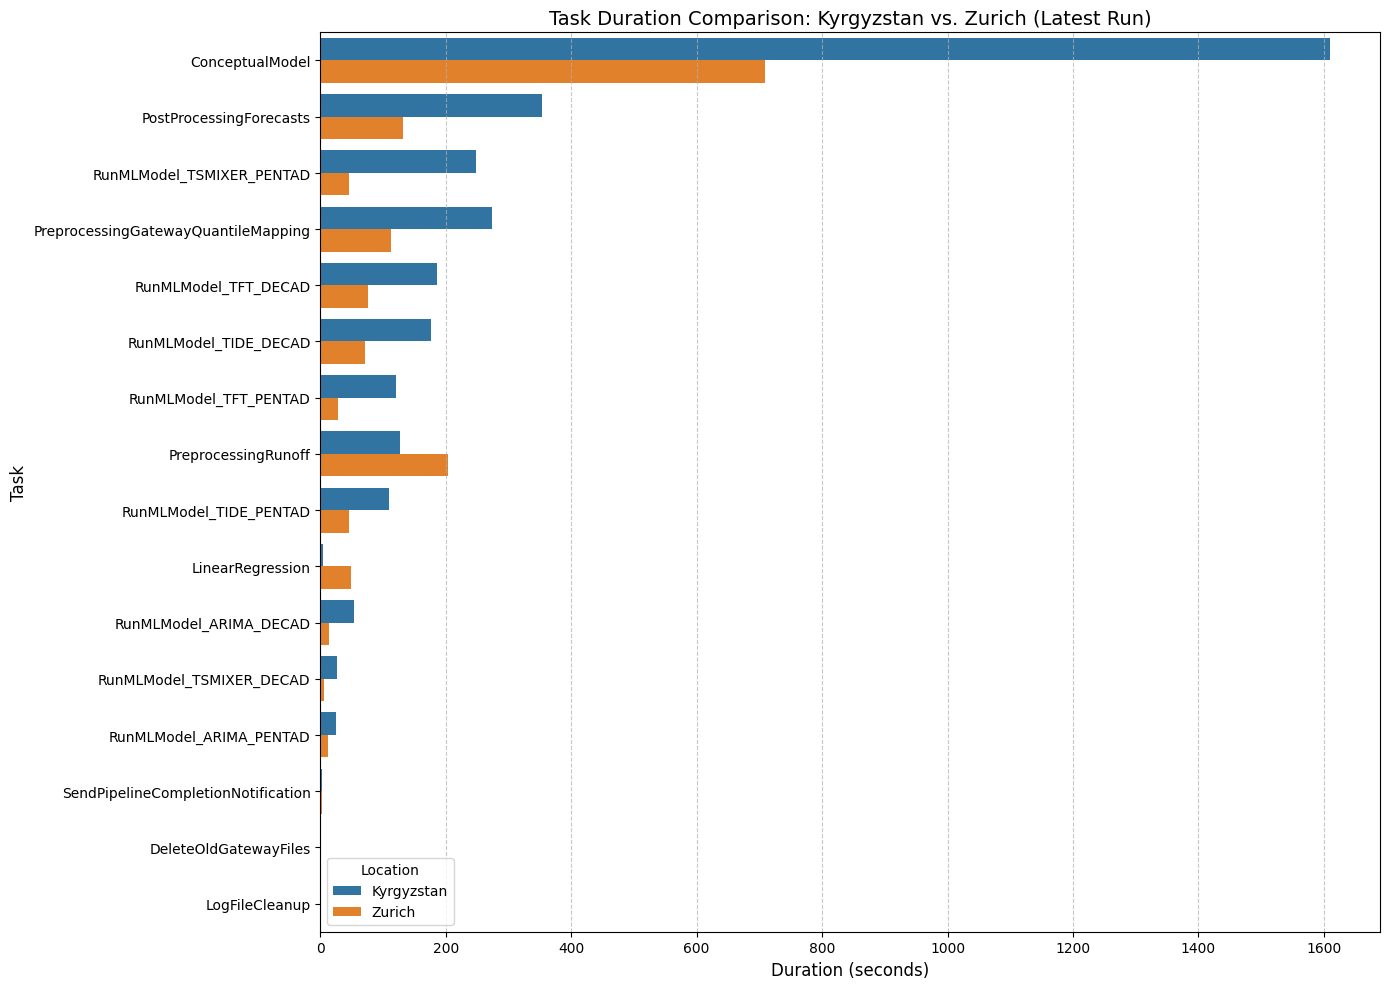

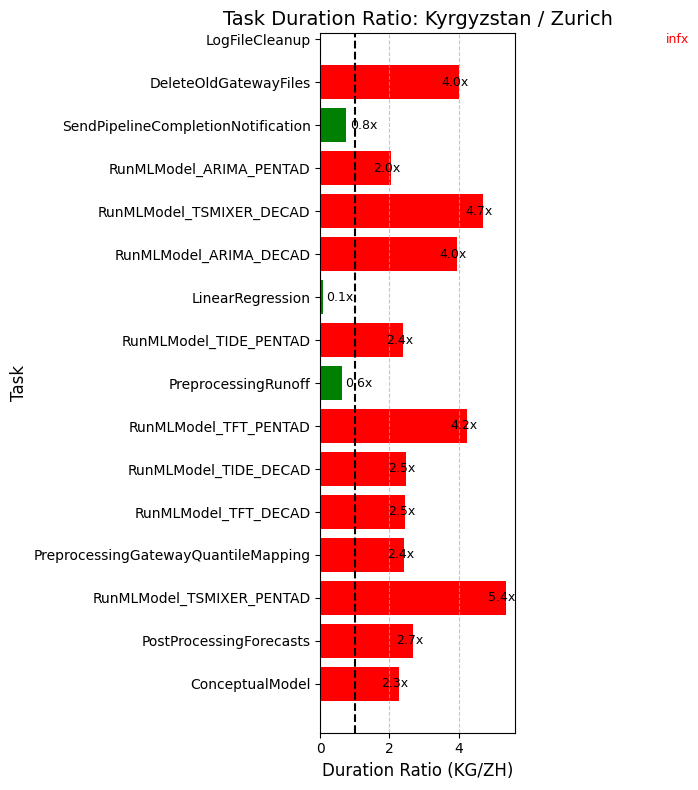

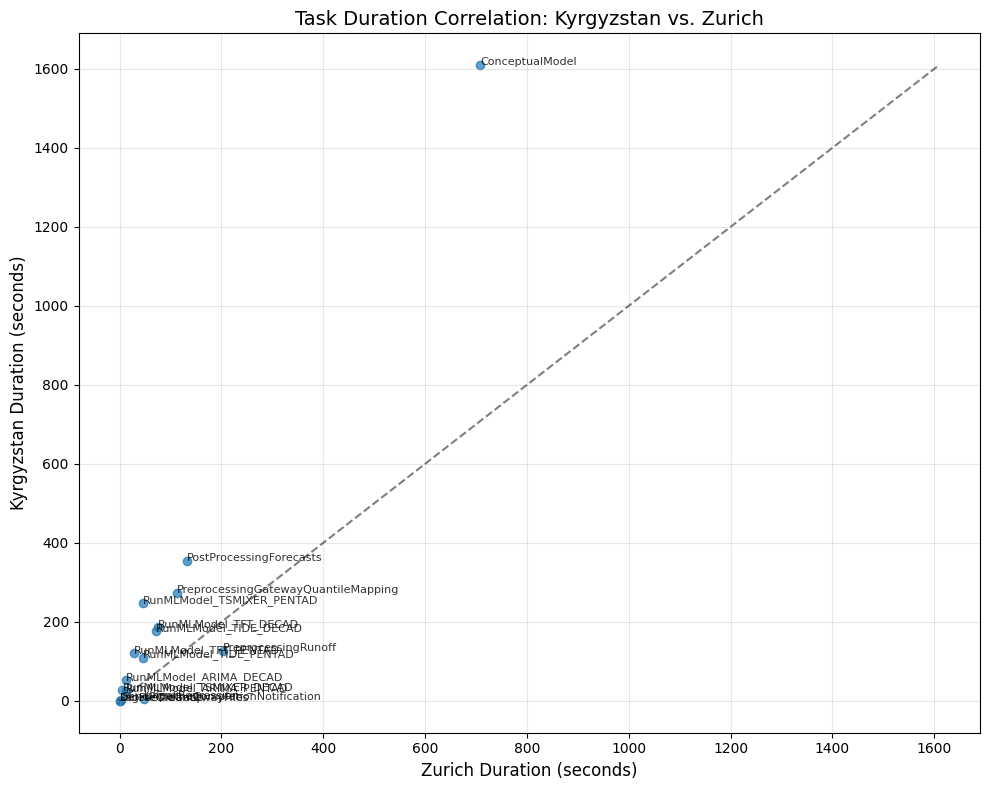

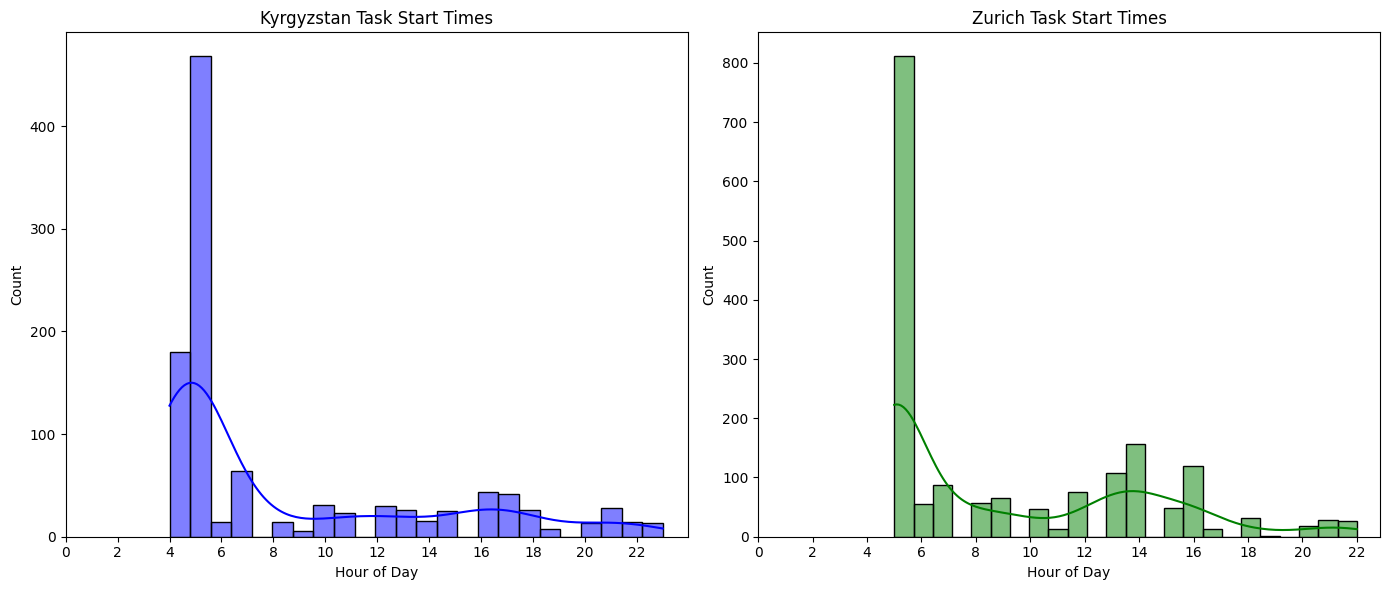

In [ ]:
import pandas as pd
import re
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Function to parse the log file
def parse_timing_log(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    # Split by separator line
    entries = content.split('--------------------------------------------------')

    # Parse each entry
    data = []
    for entry in entries:
        if not entry.strip():
            continue

        task_match = re.search(r'Task: (.*?)$', entry, re.MULTILINE)
        start_match = re.search(r'Start Time: (.*?)$', entry, re.MULTILINE)
        end_match = re.search(r'End Time: (.*?)$', entry, re.MULTILINE)
        duration_match = re.search(r'Duration: (.*?) seconds', entry, re.MULTILINE)
        status_match = re.search(r'Status: (.*?)$', entry, re.MULTILINE)
        details_match = re.search(r'Details: (.*?)$', entry, re.MULTILINE)

        if all([task_match, start_match, end_match, duration_match, status_match]):
            task = task_match.group(1).strip()
            start_time = start_match.group(1).strip()
            end_time = end_match.group(1).strip()
            duration = float(duration_match.group(1).strip())
            status = status_match.group(1).strip()
            details = details_match.group(1).strip() if details_match else ''

            data.append({
                'Task': task,
                'Start Time': datetime.fromisoformat(start_time),
                'End Time': datetime.fromisoformat(end_time),
                'Duration': duration,
                'Status': status,
                'Details': details
            })

    return pd.DataFrame(data)

# Define paths to both log files
base_path = sys.path[0] + '/../../../../sensitive_data_forecast_tools/intermediate_data/'
kg_file_path = os.path.abspath(base_path + 'task_timings_KG_20250424.log')
zh_file_path = os.path.abspath(base_path + 'task_timings_ZH_20250424.log')

# Parse both log files
df_kg = parse_timing_log(kg_file_path)
df_zh = parse_timing_log(zh_file_path)

# Add location identifier
df_kg['Location'] = 'Kyrgyzstan'
df_zh['Location'] = 'Zurich'

# Get the latest entry for each task from both locations
latest_kg = df_kg.sort_values('End Time').groupby('Task').last().reset_index()
latest_zh = df_zh.sort_values('End Time').groupby('Task').last().reset_index()

# Combine the datasets
comparison = pd.merge(
    latest_kg[['Task', 'Duration', 'Start Time', 'End Time']],
    latest_zh[['Task', 'Duration', 'Start Time', 'End Time']],
    on='Task',
    suffixes=('_KG', '_ZH')
)

# Calculate the difference and ratio
comparison['Duration_Diff_KG_ZH'] = comparison['Duration_KG'] - comparison['Duration_ZH']
comparison['Duration_Ratio_KG_ZH'] = comparison['Duration_KG'] / comparison['Duration_ZH']
comparison['Time_Between_Runs'] = (comparison['Start Time_KG'] - comparison['Start Time_ZH']).dt.total_seconds() / 3600  # in hours

# Sort by the absolute difference
comparison = comparison.sort_values('Duration_Diff_KG_ZH', key=abs, ascending=False)

# Display the comparison
print("Task Timing Comparison (Latest Run per Task) - KG vs ZH:")
print(comparison[['Task', 'Duration_KG', 'Duration_ZH', 'Duration_Diff_KG_ZH', 'Duration_Ratio_KG_ZH']])

# Create a combined dataframe for plotting
plot_data = pd.DataFrame({
    'Task': comparison['Task'],
    'Kyrgyzstan': comparison['Duration_KG'],
    'Zurich': comparison['Duration_ZH']
})

# Reshape for seaborn
plot_data_melted = pd.melt(plot_data, id_vars=['Task'], var_name='Location', value_name='Duration')

# Bar plot comparing durations
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='Duration', y='Task', hue='Location', data=plot_data_melted)
plt.title('Task Duration Comparison: Kyrgyzstan vs. Zurich (Latest Run)', fontsize=14)
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Task', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Ratio plot (KG/ZH)
plt.figure(figsize=(14, 8))
bars = plt.barh(comparison['Task'], comparison['Duration_Ratio_KG_ZH'], color=np.where(comparison['Duration_Ratio_KG_ZH'] > 1, 'red', 'green'))
plt.axvline(x=1, color='black', linestyle='--')
plt.title('Task Duration Ratio: Kyrgyzstan / Zurich', fontsize=14)
plt.xlabel('Duration Ratio (KG/ZH)', fontsize=12)
plt.ylabel('Task', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add text labels with actual values
for i, bar in enumerate(bars):
    ratio = comparison['Duration_Ratio_KG_ZH'].iloc[i]
    if ratio > 10:
        # Position for extremely large values
        plt.text(10, bar.get_y() + bar.get_height()/2, f"{ratio:.1f}x", va='center', fontsize=9, color='red')
    elif ratio > 1:
        plt.text(ratio - 0.5, bar.get_y() + bar.get_height()/2, f"{ratio:.1f}x", va='center', fontsize=9)
    else:
        plt.text(ratio + 0.1, bar.get_y() + bar.get_height()/2, f"{ratio:.1f}x", va='center', fontsize=9)

plt.tight_layout()

# Create scatter plot to see correlation between task durations
plt.figure(figsize=(10, 8))
plt.scatter(comparison['Duration_ZH'], comparison['Duration_KG'], alpha=0.7)

# Add reference line (y=x)
max_val = max(comparison['Duration_KG'].max(), comparison['Duration_ZH'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

# Add task labels
for i, txt in enumerate(comparison['Task']):
    plt.annotate(txt, (comparison['Duration_ZH'].iloc[i], comparison['Duration_KG'].iloc[i]),
                fontsize=8, alpha=0.8)

plt.title('Task Duration Correlation: Kyrgyzstan vs. Zurich', fontsize=14)
plt.xlabel('Zurich Duration (seconds)', fontsize=12)
plt.ylabel('Kyrgyzstan Duration (seconds)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Identify the tasks with the most significant slowdowns in Kyrgyzstan
print("\nTasks with Greatest Slowdown in Kyrgyzstan:")
slowdowns = comparison.sort_values('Duration_Ratio_KG_ZH', ascending=False)
print(slowdowns[slowdowns['Duration_Ratio_KG_ZH'] > 1][['Task', 'Duration_KG', 'Duration_ZH', 'Duration_Ratio_KG_ZH']].head(5))

# Calculate total pipeline time comparison
kg_pipeline_time = latest_kg['Duration'].sum()
zh_pipeline_time = latest_zh['Duration'].sum()
print(f"\nTotal Pipeline Duration Comparison:")
print(f"Kyrgyzstan: {kg_pipeline_time:.1f} seconds ({kg_pipeline_time/60:.1f} minutes)")
print(f"Zurich: {zh_pipeline_time:.1f} seconds ({zh_pipeline_time/60:.1f} minutes)")
print(f"Difference: {kg_pipeline_time - zh_pipeline_time:.1f} seconds ({(kg_pipeline_time - zh_pipeline_time)/60:.1f} minutes)")
print(f"Ratio: {kg_pipeline_time / zh_pipeline_time:.2f}x")

# Time of day analysis
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_kg['Start Time'].dt.hour, bins=24, kde=True, color='blue')
plt.title('Kyrgyzstan Task Start Times')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 24, 2))

plt.subplot(1, 2, 2)
sns.histplot(df_zh['Start Time'].dt.hour, bins=24, kde=True, color='green')
plt.title('Zurich Task Start Times')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 24, 2))

plt.tight_layout()

# Show plots
plt.show()

# Export the comparison to CSV
#comparison.to_csv('kg_zh_task_comparison.csv', index=False)
#print("\nComparison data saved to kg_zh_task_comparison.csv")